<a href="https://colab.research.google.com/github/Ger-oc/YOLOV3_FireAndSmokeDetection/blob/main/YoloV3_FireDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow
!pip install torchviz
!pip install graphviz


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from roboflow import Roboflow
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np
import glob
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
rf = Roboflow(api_key="0Z4VoCgLChWeuoeTexjI")
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Path to the YAML file
file_path = f'{dataset.location}/data.yaml'

# Read the YAML file
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# Update paths for train, val, and test
base_path = dataset.location
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/valid/images"
data['test'] = f"{base_path}/test/images"

# Save the updated YAML data back to the file
with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Paths updated successfully!")
print(f"{base_path}")

Paths updated successfully!
/content/Fire-Smoke-Detection-Yolov11-2


In [5]:
from pprint import pprint

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

pprint(data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'fire-smoke-detection-yolov11',
              'url': 'https://universe.roboflow.com/sayed-gamal-kn2wu/fire-smoke-detection-yolov11/dataset/2',
              'version': 2,
              'workspace': 'sayed-gamal-kn2wu'},
 'test': '/content/Fire-Smoke-Detection-Yolov11-2/test/images',
 'train': '/content/Fire-Smoke-Detection-Yolov11-2/train/images',
 'val': '/content/Fire-Smoke-Detection-Yolov11-2/valid/images'}


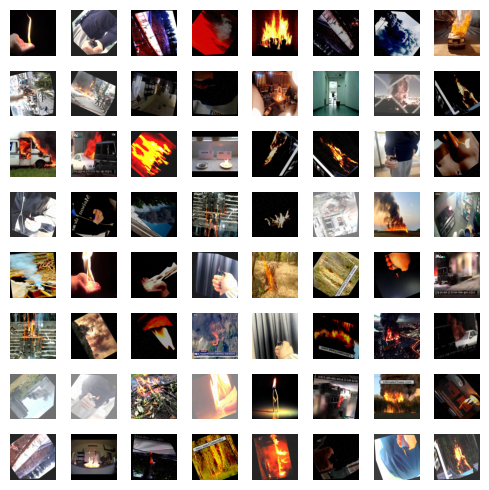

(640, 640, 3)


In [6]:
# Define dataset image path
image_folder = f"{dataset.location}/train/images"

# Get the first few image filenames 8*8=64 in our case here
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))][:64]

# Set up plot grid (8*8)
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Loop through and plot images
for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        img_path = os.path.join(image_folder, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")

plt.tight_layout()
plt.show()
print(img.shape)

# Class Distribution

In [7]:
# Written Using colab, modify path for your system
label_folder_train = r"/content/Fire-Smoke-Detection-Yolov11-2/train/labels"
label_folder_val = r"/content/Fire-Smoke-Detection-Yolov11-2/valid/labels"
label_folder_test = r"/content/Fire-Smoke-Detection-Yolov11-2/test/labels"


def get_class_distribution(label_folder):
    class_counts = Counter()  # Initialize inside function
    bounded_boxes = []

    annotation_files = glob.glob(os.path.join(label_folder, '*.txt'))

    for filename in annotation_files:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                segments = line.strip().split()
                if len(segments) == 5:
                    class_id = int(segments[0])
                    x_center, y_center, width, height = map(float, segments[1:])
                    class_counts[class_id] += 1
                    bounded_boxes.append([x_center, y_center, width, height])
                else:
                    print(len(segments), "Skipping line with unexpected format:", segments)

    return class_counts, bounded_boxes

class_counts, bounded_boxes = get_class_distribution(label_folder_train)

box_df = pd.DataFrame(bounded_boxes, columns=['x_center', 'y_center', 'width', 'height'])

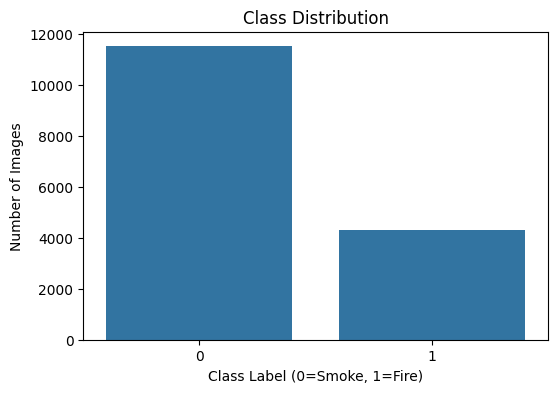

In [8]:
if class_counts:
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution')
    plt.xlabel('Class Label (0=Smoke, 1=Fire)')
    plt.ylabel('Number of Images')
    plt.xticks([0, 1])
    plt.show()
else:
    print("No class distribution data available.") #Debug statment, No graph info means path above is wrong

Text(0, 0.5, 'Frequency')

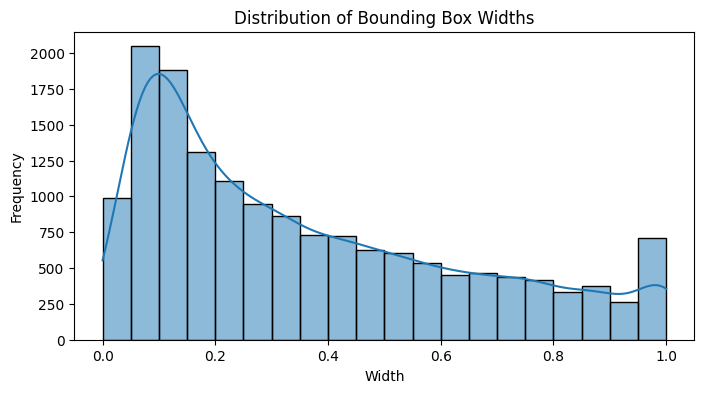

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(box_df['width'], bins=20, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

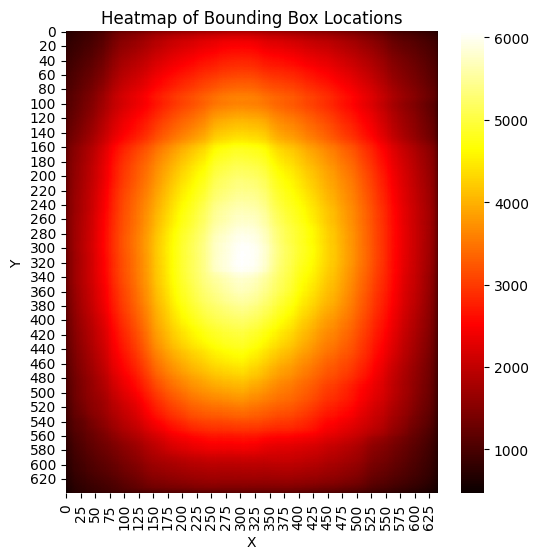

In [10]:
heatmap = np.zeros((640, 640))

for _, row in box_df.iterrows():
  x,y,w,h = row['x_center'], row['y_center'], row['width'], row['height']
  x1, y1 = int((x - w/2) * 640), int((y - h/2) * 640)
  x2, y2 = int((x + w/2) * 640), int((y + h/2) * 640)
  heatmap[y1:y2, x1:x2] += 1

plt.figure(figsize=(6,6))
sns.heatmap(heatmap, cmap='hot', cbar=True)
plt.title('Heatmap of Bounding Box Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Model


Define Convolutional Block, This headder is used for both darknet and yolo

In [11]:
class ConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvUnit, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))


ResidualUnit is used a few times in darknet

In [12]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels):
        super(ResidualUnit, self).__init__()
        self.conv1 = ConvUnit(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvUnit(in_channels//2, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))  # Skip connection


In [13]:
class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53, self).__init__()

        self.conv1 = ConvUnit(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvUnit(32, 64, kernel_size=3, stride=2, padding=1)
        self.res1 = ResidualUnit(64)

        self.conv3 = ConvUnit(64, 128, kernel_size=3, stride=2, padding=1)
        self.res2 = nn.Sequential(ResidualUnit(128), ResidualUnit(128))

        self.conv4 = ConvUnit(128, 256, kernel_size=3, stride=2, padding=1)
        self.res3 = nn.Sequential(*[ResidualUnit(256) for _ in range(8)])

        self.conv5 = ConvUnit(256, 512, kernel_size=3, stride=2, padding=1)
        self.res4 = nn.Sequential(*[ResidualUnit(512) for _ in range(8)])

        self.conv6 = ConvUnit(512, 1024, kernel_size=3, stride=2, padding=1)
        self.res5 = nn.Sequential(*[ResidualUnit(1024) for _ in range(4)])

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)
        x = self.conv3(x)
        x = self.res2(x)
        x = self.conv4(x)
        x = self.res3(x)
        x = self.conv5(x)
        x = self.res4(x)
        x = self.conv6(x)
        x = self.res5(x)
        return x  # Feature map used in YOLO detection head


Yolo Head

In [14]:
class YOLOHead(nn.Module):
    def __init__(self, num_classes):
        super(YOLOHead, self).__init__()
        self.conv1 = ConvUnit(1024, 512, 1, 1, 0)
        self.conv2 = ConvUnit(512, 1024, 3, 1, 1)
        self.conv3 = nn.Conv2d(1024, (num_classes + 5) * 3, kernel_size=1)  # 3 anchors per grid cell

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x).reshape(x.shape[0], 3, -1, x.shape[2], x.shape[3])  # Reshape for YOLO anchors


Combine Yolo and Darknet Head

In [15]:
class YOLOv3(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOv3, self).__init__()
        self.backbone = Darknet53()
        self.yolo_head = YOLOHead(num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return self.yolo_head(x)


# Loss Function

In [16]:
class YOLOLoss(nn.Module):
    def __init__(self, num_classes, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss()  # For bounding box regression
        self.bce_loss = nn.BCEWithLogitsLoss()  # For objectness & class predictions

    def forward(self, predictions, targets):
        """
        Compute YOLO loss.

        Args:
        - predictions: Tensor of shape (batch_size, num_anchors, 7, grid_size, grid_size)
        - targets: Tensor of same shape as `predictions`

        Returns:
        - Total YOLO loss
        """
        # Reshape targets if necessary
        if targets.shape != predictions.shape:
            targets = targets.view_as(predictions)  # Match shape if needed

        # Extract components
        pred_boxes = predictions[:, :, :4]  # x, y, w, h
        pred_obj = predictions[:, :, 4]  # Object confidence score
        pred_class = predictions[:, :, 5:]  # Class probabilities

        target_boxes = targets[:, :, :4]  # Ground truth bbox
        target_obj = targets[:, :, 4]  # Ground truth objectness score
        target_class = targets[:, :, 5:]  # Ground truth class

        # Compute Bounding Box Loss (MSE)
        bbox_loss = self.mse_loss(pred_boxes, target_boxes)

        # Compute Objectness Loss (BCE)
        obj_loss = self.bce_loss(pred_obj, target_obj)

        # Compute Classification Loss (BCE)
        class_loss = self.bce_loss(pred_class, target_class)

        # Total Loss
        total_loss = (self.lambda_coord * bbox_loss) + obj_loss + (class_loss)

        return total_loss

In [17]:
# Initialize YOLO loss function
num_classes = 2  # Fire and Smoke
yolo_loss = YOLOLoss(num_classes)

# Generate random predictions & targets (simulating model output)
batch_size = 1
num_anchors = 3
grid_size = 13  # YOLOv3 uses 13x13, 26x26, and 52x52 grids

# Fake predictions: [batch, anchors, 7 (x, y, w, h, obj, class1, class2), grid, grid]
preds = torch.rand((batch_size, num_anchors, 7, grid_size, grid_size))

# Fake targets (ground truth labels in the same format)
targets = torch.rand((batch_size, num_anchors, 7, grid_size, grid_size))

# Compute loss
loss = yolo_loss(preds, targets)

print("Loss function test successful! Sample loss:", loss.item())
print("Out put should be possitive and small")



Loss function test successful! Sample loss: 2.3044676780700684
Out put should be possitive and small


In [18]:
class FireDataset(Dataset):
    def __init__(self, image_folder, label_folder, img_size=416, grid_size=13, num_anchors=3, num_classes=2):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.img_size = img_size
        self.grid_size = grid_size
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        self.image_files = sorted(os.listdir(image_folder))
        self.label_files = sorted(os.listdir(label_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image / 255.0  # Normalize to [0,1]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # Load label
        label_path = os.path.join(self.label_folder, self.label_files[idx])
        labels = torch.zeros((self.num_anchors, 7, self.grid_size, self.grid_size))  # Empty grid

        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x, y, w, h = map(float, parts)

                    # 🔹 Fix: Ensure grid coordinates stay within bounds
                    x_cell = min(int(x * self.grid_size), self.grid_size - 1)
                    y_cell = min(int(y * self.grid_size), self.grid_size - 1)

                    labels[:, :4, y_cell, x_cell] = torch.tensor([x, y, w, h])
                    labels[:, 4, y_cell, x_cell] = 1.0  # Object confidence
                    labels[:, 5 + int(class_id), y_cell, x_cell] = 1.0  # Class

        return image, labels  # Now labels match YOLO format



In [19]:
image_folder = "/content/Fire-Smoke-Detection-Yolov11-2/train/images"
label_folder = "/content/Fire-Smoke-Detection-Yolov11-2/train/labels"
dataset = FireDataset(image_folder, label_folder)

def collate_fn(batch):
    images, labels = zip(*batch)  # Unpack batch (tuple of images, labels)

    # Stack images into a single tensor batch
    images = torch.stack(images)

    # Stack labels properly
    labels = torch.stack(labels)

    return images, labels  # Now both images and labels are tensors

#CHANGE BATCH SIZE HERE!!!!!!!!!   32 is right on the limit at 14.1 out of 15. reduce if crashing for you
# Create DataLoader with fixed collate_fn   BATCH SIZE CHNAGE HERE
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Verify the fix
for img, label in dataloader:
    print(" Dataset loaded successfully!")
    print(" Image Batch Shape:", img.shape)  # Expected: (batch_size, 3, 416, 416)
    print(" Label Batch Shape:", label.shape)  # Expected: (batch_size, max_objs, 5)
    break  # Stop after first batch


 Dataset loaded successfully!
 Image Batch Shape: torch.Size([32, 3, 416, 416])
 Label Batch Shape: torch.Size([32, 3, 7, 13, 13])


# Train

In [20]:
# Check if the DataLoader is loading images // DEBUG statment
#for batch_idx, (images, labels) in enumerate(dataloader):
#    print(f" Batch {batch_idx+1}: Loaded {len(images)} images")
#    print(f" Image Tensor Shape: {images.shape}")  # Expected: (batch_size, 3, 416, 416)
#    print(f" Label Tensor Shape: {labels.shape}")  # Expected: (batch_size, num_anchors, 7, grid, grid)
#    break  # Stop after one batch


In [21]:
#Checking device its running on
print("Device in Use:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Device in Use: Tesla T4


In [22]:
#Checking batch size
for images, labels in dataloader:
    print(f"Batch Size: {images.shape[0]}")  # Should match new batch size
    break  # Stop after first batch


Batch Size: 32


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOv3(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = YOLOLoss(num_classes=2)  # You need to define this


In [24]:
def train(model, dataloader, optimizer, loss_function, epochs, save_path="yolov3_fire_final.pth"):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = 0
        batch_losses = []  # Store batch losses for reporting
        all_preds = []  # Store all predictions
        all_targets = []  # Store all ground truth labels

        print(f"\n Epoch {epoch+1}/{epochs} - Training Started...")

        for batch_idx, (images, targets) in enumerate(dataloader):
            images = images.to(device)

            # Ensure targets are tensors & move to device
            if isinstance(targets, list):
                targets = torch.stack(targets).to(device)
            else:
                targets = targets.to(device)

            preds = model(images)  # Forward pass

            # Ensure target shape matches prediction shape
            if targets.shape != preds.shape:
                print(f"Skipping Batch {batch_idx+1} - Shape Mismatch: Targets {targets.shape}, Preds {preds.shape}")
                continue  # Skip this batch

            loss = loss_function(preds, targets)  # Compute YOLO loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_losses.append(loss.item())

            # Convert predictions to binary (1 = fire detected, 0 = no fire)
            pred_labels = (preds[:, :, 4] > 0.5).float().cpu().numpy()  # Objectness score thresholded
            true_labels = (targets[:, :, 4] > 0.5).float().cpu().numpy()  # Ground truth

            all_preds.extend(pred_labels.flatten())  # Store predictions
            all_targets.extend(true_labels.flatten())  # Store true labels

            # Print only every 20 batches
            if batch_idx % 20 == 0:
                avg_loss = sum(batch_losses) / len(batch_losses)
                print(f" Batch {batch_idx+1}/{len(dataloader)} - Avg Loss: {avg_loss:.4f}")

        # Compute Precision, Recall, and F1 Score
        precision = precision_score(all_targets, all_preds, zero_division=1)
        recall = recall_score(all_targets, all_preds, zero_division=1)
        f1 = f1_score(all_targets, all_preds, zero_division=1)

        print(f" Epoch {epoch+1}/{epochs} - Total Loss: {total_loss:.4f}")
        print(f" Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # 🔹 Save model **ONLY after training is complete**
    torch.save(model.state_dict(), save_path)
    print(f" Model saved at {save_path}")


In [25]:
num_epochs = 5  # Adjust this number as needed
train(model, dataloader, optimizer, yolo_loss, epochs=num_epochs)


 Epoch 1/5 - Training Started...
 Batch 1/287 - Avg Loss: 2.2012
 Batch 21/287 - Avg Loss: 2.3236
 Batch 41/287 - Avg Loss: 1.2608
 Batch 61/287 - Avg Loss: 0.8846
 Batch 81/287 - Avg Loss: 0.6926
 Batch 101/287 - Avg Loss: 0.5751
 Batch 121/287 - Avg Loss: 0.4958
 Batch 141/287 - Avg Loss: 0.4395
 Batch 161/287 - Avg Loss: 0.3976
 Batch 181/287 - Avg Loss: 0.3646
 Batch 201/287 - Avg Loss: 0.3378
 Batch 221/287 - Avg Loss: 0.3161
 Batch 241/287 - Avg Loss: 0.2979
 Batch 261/287 - Avg Loss: 0.2822
 Batch 281/287 - Avg Loss: 0.2690
 Epoch 1/5 - Total Loss: 76.1347
 Precision: 0.0191, Recall: 0.0003, F1 Score: 0.0005

 Epoch 2/5 - Training Started...
 Batch 1/287 - Avg Loss: 0.0987
 Batch 21/287 - Avg Loss: 0.0884
 Batch 41/287 - Avg Loss: 0.0922
 Batch 61/287 - Avg Loss: 0.0918
 Batch 81/287 - Avg Loss: 0.0916
 Batch 101/287 - Avg Loss: 0.0920
 Batch 121/287 - Avg Loss: 0.0918
 Batch 141/287 - Avg Loss: 0.0912
 Batch 161/287 - Avg Loss: 0.0909
 Batch 181/287 - Avg Loss: 0.0913
 Batch 2

# TEST

In [26]:
model = YOLOv3(num_classes=2)  # Initialize the model architecture
model.load_state_dict(torch.load("yolov3_fire_final.pth"))  # Load trained weights
model.to(device)  # Move to GPU/CPU
model.eval()  # Set model to evaluation mode


YOLOv3(
  (backbone): Darknet53(
    (conv1): ConvUnit(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (conv2): ConvUnit(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (res1): ResidualUnit(
      (conv1): ConvUnit(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_relu): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvUnit(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05,

In [69]:
def detect_fire(model, image_path, conf_threshold=0.02, iou_threshold=0.4):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load image '{image_path}'")
        return None

    image = cv2.resize(image, (416, 416))
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        preds = model(image)

    # 🔹 Apply sigmoid to confidence scores (objectness)
    preds[..., 4] = torch.sigmoid(preds[..., 4])

    # 🔹 Apply sigmoid to class scores
    preds[..., 5:] = torch.sigmoid(preds[..., 5:])

    preds = non_max_suppression(preds, conf_threshold, iou_threshold)

    if not preds or len(preds) == 0:
        print("⚠ No detections found after NMS.")

    return preds

# 🔹 IoU Function (Placed Outside detect_fire)
def iou(box1, box2):
    """
    Compute IoU (Intersection over Union) between two bounding boxes.
    """
    # Get coordinates
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    # Compute intersection area
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Compute union area
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = box1_area + box2_area - intersection

    return intersection / union

# 🔹 Run Fire Detection
fire_detections = detect_fire(model, "/content/fire_image.jpg")
print(fire_detections)


[tensor([[-5.6318e-03, -3.0487e-03,  5.0251e-01,  ...,  5.5582e-01,
          4.9897e-01,  4.9757e-01],
        [ 5.0409e-01,  5.0279e-01,  5.0535e-01,  ...,  5.3036e-01,
          4.9832e-01,  4.9662e-01],
        [ 5.0221e-01,  5.0184e-01,  5.0317e-01,  ...,  5.2683e-01,
          4.9815e-01,  4.9648e-01],
        ...,
        [ 4.9712e-01,  4.9835e-01,  4.9896e-01,  ...,  2.4715e-02,
          1.6762e-02,  1.4326e-02],
        [-4.5958e+00,  1.8837e-02,  1.6962e-01,  ...,  2.3919e-02,
          2.1218e-03,  6.3231e-04],
        [ 4.9617e-01,  4.9604e-01,  4.9781e-01,  ...,  2.0507e-02,
          1.8948e-02,  2.2005e-02]], device='cuda:0')]


In [59]:
print("📌 Model Device:", next(model.parameters()).device)
print("📂 Model Parameters Loaded:", any(p.requires_grad for p in model.parameters()))


📌 Model Device: cuda:0
📂 Model Parameters Loaded: True


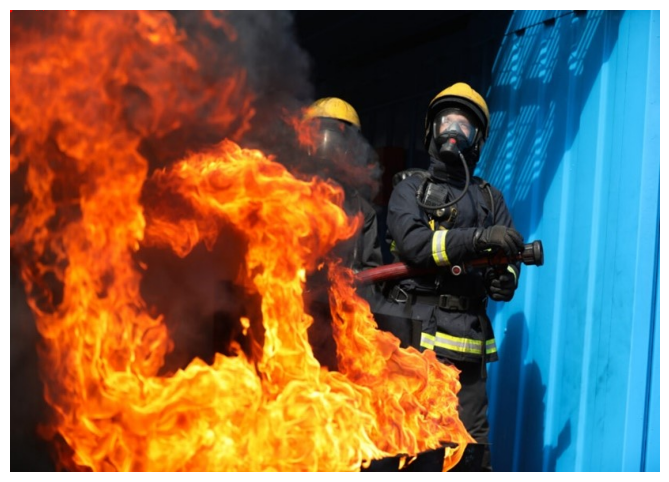

In [71]:
def detect_fire(model, image_path, conf_threshold=0.02, iou_threshold=0.4):
    """
    Detects fire in an image using a trained YOLO model.

    Args:
    - model: Trained YOLO model
    - image_path: Path to the image to detect fire
    - conf_threshold: Confidence threshold for detections (default 0.02)
    - iou_threshold: IoU threshold for non-max suppression (default 0.4)

    Returns:
    - Detections with bounding boxes, confidence scores, and class probabilities
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load image '{image_path}'")
        return None

    image = cv2.resize(image, (416, 416))
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        preds = model(image)

    # Apply sigmoid activation to confidence and class scores
    preds[..., 4] = torch.sigmoid(preds[..., 4])  # Object confidence
    preds[..., 5:] = torch.sigmoid(preds[..., 5:])  # Class scores

    # Apply Non-Maximum Suppression (NMS)
    preds = non_max_suppression(preds, conf_threshold, iou_threshold)

    if not preds or len(preds) == 0:
        print("⚠ No detections found after NMS.")

    return preds

def iou(box1, box2):
    """
    Compute IoU (Intersection over Union) between two bounding boxes.
    """
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = box1_area + box2_area - intersection

    return intersection / union

def visualize_detections(image_path, detections, orig_size=(640, 480)):  # Adjust original size if needed
    image = cv2.imread(image_path)
    h, w, _ = image.shape  # Get original image size
    scale_x, scale_y = w / 416, h / 416  # Compute scaling factors

    for box in detections:
        x_center, y_center, width, height, conf, class1, class2 = box.cpu().numpy()

        # Convert from YOLO format to rectangle coordinates
        x1 = int((x_center - width / 2) * scale_x)
        y1 = int((y_center - height / 2) * scale_y)
        x2 = int((x_center + width / 2) * scale_x)
        y2 = int((y_center + height / 2) * scale_y)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(image, f"Fire ({conf:.2f})", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# 🔹 Run Detection & Visualization
detections = detect_fire(model, "/content/fire_image.jpg")
if detections and len(detections) > 0:
    visualize_detections("/content/fire_image.jpg", detections[0])

# Visuals

In [29]:
print(model)


YOLOv3(
  (backbone): Darknet53(
    (conv1): ConvUnit(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (conv2): ConvUnit(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (res1): ResidualUnit(
      (conv1): ConvUnit(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_relu): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvUnit(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05,

In [30]:
from torchsummary import summary

# Ensure model is on the correct device (GPU/CPU)
model.to(device)

# Print model summary for input size (3, 416, 416)
summary(model, (3, 416, 416))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          ConvUnit-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          ConvUnit-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         ConvUnit-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

In [32]:
import torchviz
from torchviz import make_dot

# Generate a dummy input to visualize the computation graph
dummy_input = torch.randn(1, 3, 416, 416).to(device)
output = model(dummy_input)

# Create the visualization
make_dot(output, params=dict(model.named_parameters())).render("yolo_graph", format="png")

print("Model graph saved as 'yolo_graph.png'")


ModuleNotFoundError: No module named 'torchviz'